# basic cnn lstm model design

CNN LSTM models have more than one specific type of a "depth" they bring to bear on a given problem.

first, CNN LSTMs have a *depth of time*: think [back propogation through time (BPTT)](https://en.wikipedia.org/wiki/Backpropagation_through_time "back propogation through time") and/or [truncated back propogation through time (TBPTT)](https://r2rt.com/styles-of-truncated-backpropagation.html "truncated back propogation through time").

CNN LSTM models also have a *depth of space*, with their multiple layers--convolutional, pooling, lstm etc--creating a deep, highly specialized and memory-persistent network.

>*[CNN LSTMs are] a class of models that is both spatially and temporally deep,
and has the flexibility to be applied to a variety of vision tasks involving sequential
inputs and outputs*
>
>— Long-term Recurrent Convolutional Networks for Visual Recognition and Description, 2015

in CNN LSTM architecture, convolutional neural networks act as encoders, effectively translating visual imagery into vector space--such that an LSTM RNN can effectively process it.

CNNs "in the wild" (as it were) are usually designed to process a single image at a time. however, with a few adjustments they can provide effective [feature extraction](https://en.wikipedia.org/wiki/Feature_extraction "feature extraction") for visual time sequence data, like video.

of course, time series problems are perfect for cells with longer-term "memory", like LSTMs.

in this notebook, we'll use a visual time series problem--specifically, the task of classifying a simple video--to illustrate the `keras` api for CNN LSTM model design.

#### two models working as one

to build the model, we'll start by defining a convolutional neural network with 2D conv and max pooling layers--standard CNN stuff.

we'll then use the `keras` `TimeDistributed()` wrapper to prepare the CNN to output series data that an LSTM expects.

once our CNN is time-distributed, we can connect it to an LSTM and start classifying videos.

## data

this video prediction problem centers on the model's ability, given several frames of a line moving across a box, to properly classify which direction the line is moving in.

the problem is contrived so that the data will be easy to generate (and also thus unlimited), but it does demonstrate the CNNs ability to encode & extract features from visual data, and the LSTM's ability to find some order (and retain that order) over the course of analyzing a sequence of information.

*(python script to generate this data, with a few modifications, is from [jason brownlee's excellent course in LSTMs](www.machinelearningmastery.com), available at www.machinelearningmastery.com)*

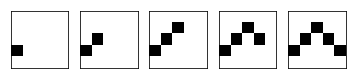

In [10]:
from numpy import zeros
from random import randint
from random import random
from matplotlib import pyplot
%matplotlib inline

# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
    
    # define the scope of the next step
    lower = max(0, last_step-1)
    upper = min(last_frame.shape[0]-1, last_step+1)
    
    # choose the row index for the next step
    step = randint(lower, upper)
    
    # copy the prior frame
    frame = last_frame.copy()
    
    # add the new step
    frame[step, column] = 1
    
    return frame, step

# generate a sequence of frames of a dot moving across an image
def build_frames(size):
    
    frames = list()
    
    # create the first frame
    frame = zeros((size,size))
    
    step = randint(0, size-1)

    # decide if we are heading left or right
    right = 1 if random() < 0.5 else 0
    
    col = 0 if right else size-1
    
    frame[step, col] = 1
    
    frames.append(frame)

    # create all remaining frames
    for i in range(1, size):
        
        col = i if right else size-1-i
        
        frame, step = next_frame(step, frame, col)
        
        frames.append(frame)
    
    return frames, right

# generate sequence of frames
size = 5

frames, right = build_frames(size)

# plot all frames
pyplot.figure()

for i in range(size):
    
    # create a gray scale subplot for each frame
    pyplot.subplot(1, size, i+1)
    
    pyplot.imshow(frames[i], cmap='Greys')

    # turn of the scale to make it clearer
    ax = pyplot.gca()
    
    ax.get_xaxis().set_visible(False)
    
    ax.get_yaxis().set_visible(False)
    

with the functions above, we can generate a pseudorandom sequence of images like these as many times as we want.

>*it's worth noting here that many apparently [stochastic](https://en.wikipedia.org/wiki/Stochastic_process "stochastic processes") processes in fact follow predictable [distributions](https://en.wikipedia.org/wiki/Gaussian_process "wikipedia: gaussian distribution") and thus pseudorandom generation should be sufficient for our data purposes.*

## preparing data for a 2d cnn

a 2d convolutional neural network normally accepts data in 3 dimensions: *width, height,* and *channels*.

our data has:

* the __same width__ and __height__, equal to `size` in the data-generation function above

* 1 __channel__ (greyscale)

we can begin to define our 2d CNN input as `[size, size, 1]`.

### multiple time steps as input to CNNs

the vector `[size, size, 1]` would work for a single image fed into a cnn. however, we have *multiple images*, i.e. __multiple time steps__.

on top of this, we have multiple instances (samples) of each set of time steps.

__we need more dimensions__.

adding time steps and samples as input dimensions gives us the vector `[n_samples, n_timesteps, size, size, 1]`.

because the function above generates a number of timesteps equal to whatever the `size` variable is set to, __our version of this input shape is__
> `[n_samples, size, size, size, 1]`

with this in mind, it's easy to build a function that generates data for us, immediately reshaping it into a format suitable for multiple time steps as input to a cnn:

In [11]:
def make_samples(size, n_samples):
    
    X, y = list(), list()
    
    for sample in range(n_samples):
        
        frames, right = build_frames(size)
        
        # this is where our frames go
        
        X.append(frames)
        
        # vector of boolean values for right
        
        y.append(right)
        
    # reshape the data to fit cnn
    # [n_samples, n_timesteps, width, height, channels]
    # using numpy array().reshape()
    
    X = array(X).reshape(n_samples, size, size, size, 1)
    
    y = array(y).reshape(n_samples, 1)
    
    return X, y